## StackLabs - Health Cross Sell

### Machine Learning.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import random
import pickle
from minio                   import Minio
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,roc_auc_score,classification_report
from sklearn.ensemble        import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing   import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn                 import metrics
from xgboost                 import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv('health.csv')

In [1]:
import xgboost as xgb

xgb.__version__

'1.5.0'

#### Funções

In [3]:
def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

In [4]:
data.head()

,V_age,Damage,Region,Channel,License,Insured,Age,Vintage,Rate,Response,Gender_Female,Gender_Male
0,2,1,0.279,0.209,1,0,0.517647,217,40454.0,1,0,1
1,1,0,0.024,0.209,1,0,0.894118,183,33536.0,0,0,1
2,2,1,0.279,0.209,1,0,0.552941,27,38294.0,1,0,1
3,0,0,0.024,0.354,1,1,0.247059,203,28619.0,0,0,1
4,0,0,0.048,0.354,1,1,0.341176,39,27496.0,0,1,0


#### Separando os conjuntos de dados.

In [5]:
target_name = 'Response'
X = data.drop('Response', axis=1)
y = data[target_name]

In [6]:
# Normalizando os dados
num_feat = ['Age','Rate']
mm_scaler = MinMaxScaler()
X[num_feat] = mm_scaler.fit_transform(X[num_feat])

#### Tratando classe desbalanceada

In [7]:
smt = SMOTE()

In [8]:
X, y = smt.fit_resample(X, y)

In [9]:
np.bincount(y)

array([334399, 334399])

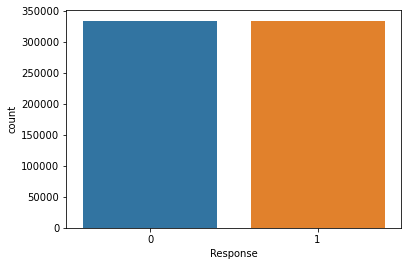

In [10]:
ax=sns.countplot(x=y)

In [11]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2 ,random_state = 123,stratify = y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((535038, 11), (535038,), (133760, 11), (133760,))

#### Análise do modelo de baseline

In [12]:
y_pred = base_rate_model(X_test)

In [13]:
print(metrics.classification_report(y_test,y_pred),'AUC:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     66880
           1       0.00      0.00      0.00     66880

    accuracy                           0.50    133760
   macro avg       0.25      0.50      0.33    133760
weighted avg       0.25      0.50      0.33    133760
 AUC: 0.5


### Modelo de Regressão Logística.

In [14]:
# Definindo Modelo
lr = LogisticRegression()

#Treinando modelo
lr.fit(X_train, y_train)

#Predição do modelo
y_pred = lr.predict(X_test)
lr_probability =lr.predict_proba(X_test)[:,1]

#Metricas
AUC_lr=roc_auc_score(y_pred,y_test)
acc_lr=accuracy_score(y_test,y_pred)
recall_lr=recall_score(y_test,y_pred)
precision_lr=precision_score(y_test,y_pred)
f1score_lr=f1_score(y_test,y_pred)

#### Avaliando o resultado.

In [15]:
print (pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito      0      1     All
Real                         
0        39530  27350   66880
1         1466  65414   66880
All      40996  92764  133760


In [16]:
print(metrics.classification_report(y_test,y_pred),'AUC:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.59      0.73     66880
           1       0.71      0.98      0.82     66880

    accuracy                           0.78    133760
   macro avg       0.83      0.78      0.78    133760
weighted avg       0.83      0.78      0.78    133760
 AUC: 0.7845693779904306


### Modelo de Arvore Aleatória (Random Forest)

In [18]:
# definido modelo
rf = RandomForestClassifier()

#Treinando modelo
rf = rf.fit(X_train,y_train)

#predição do modelo
y_pred = rf.predict(X_test)

rf_probability =rf.predict_proba(X_test)[:,1]

#Metricas
AUC_rf=roc_auc_score(y_pred,y_test)
acc_rf=accuracy_score(y_test,y_pred)
recall_rf=recall_score(y_test,y_pred)
precision_rf=precision_score(y_test,y_pred)
f1score_rf=f1_score(y_test,y_pred)

#### Avaliando o resultado.

In [19]:
print (pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito      0      1     All
Real                         
0        60786   6094   66880
1         6145  60735   66880
All      66931  66829  133760


In [20]:
print(metrics.classification_report(y_test,y_pred),'AUC:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     66880
           1       0.91      0.91      0.91     66880

    accuracy                           0.91    133760
   macro avg       0.91      0.91      0.91    133760
weighted avg       0.91      0.91      0.91    133760
 AUC: 0.9085002990430622


### Modelo Extreme Gradient Boosting (XGBoost)

In [21]:
# Definindo Modelo
xgb=XGBClassifier()

#Treinando modelo
xgb=xgb.fit(X_train, y_train)

#Predição do Modelo
y_pred = xgb.predict(X_test)

xgb_probability =xgb.predict_proba(X_test)[:,1]

#Metricas
AUC_xgb=roc_auc_score(y_pred,y_test)
acc_xgb=accuracy_score(y_test,y_pred)
recall_xgb=recall_score(y_test,y_pred)
precision_xgb=precision_score(y_test,y_pred)
f1score_xgb=f1_score(y_test,y_pred)

[00:34:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Avaliando o resultado.

In [22]:
print (pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito      0      1     All
Real                         
0        64532   2348   66880
1         8358  58522   66880
All      72890  60870  133760


In [23]:
print(metrics.classification_report(y_test,y_pred),'AUC:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     66880
           1       0.96      0.88      0.92     66880

    accuracy                           0.92    133760
   macro avg       0.92      0.92      0.92    133760
weighted avg       0.92      0.92      0.92    133760
 AUC: 0.9199611244019138


### Modelo Gradient Boosting (GBoost)

In [24]:
#Definindo Modelo
gb= GradientBoostingClassifier()

#Treinando Modelo
gb=gb.fit(X_train, y_train)

#Predição do Modelo
y_pred = gb.predict(X_test)
gb_probability =gb.predict_proba(X_test)[:,1]

#Metricas
AUC_gb=roc_auc_score(y_pred,y_test)
acc_gb=accuracy_score(y_test,y_pred)
recall_gb=recall_score(y_test,y_pred)
precision_gb=precision_score(y_test,y_pred)
f1score_gb=f1_score(y_test,y_pred)

#### Avaliando o resultado.

In [25]:
print (pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predito'], margins=True))

Predito      0      1     All
Real                         
0        52212  14668   66880
1         4251  62629   66880
All      56463  77297  133760


In [26]:
print(metrics.classification_report(y_test,y_pred),'AUC:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.78      0.85     66880
           1       0.81      0.94      0.87     66880

    accuracy                           0.86    133760
   macro avg       0.87      0.86      0.86    133760
weighted avg       0.87      0.86      0.86    133760
 AUC: 0.8585601076555024


#### Comparando o resultado dos Modelos.

In [27]:
ind=['Logistic regression','Randomforest','XGBClassifier','GBoost']

data={"Accuracy":[acc_lr,acc_rf,acc_xgb,acc_gb],
      "Recall":[recall_lr,recall_rf,recall_xgb,recall_gb],
      "Precision":[precision_lr,precision_rf,precision_xgb,precision_gb],
      "f1_score":[f1score_lr,f1score_rf,f1score_xgb,f1score_gb],
      "ROC_AUC":[AUC_lr,AUC_rf,AUC_xgb,AUC_gb]}

result=pd.DataFrame(data=data,index=ind)
result

,Accuracy,Recall,Precision,f1_score,ROC_AUC
Logistic regression,0.784569,0.978080,0.705166,0.819498,0.834703
Randomforest,0.908500,0.908119,0.908812,0.908465,0.908501
XGBClassifier,0.919961,0.875030,0.961426,0.916196,0.923380
GBoost,0.858560,0.936438,0.810238,0.868779,0.867475


#### Salvando Modelo

In [30]:
pickle.dump(rf,open('model.pkl','wb'))